# Итоговая расчетная работа

Порядок действий:

1. Перейдем от передаточной функции к ДУ; Решим ДУ явным методом Эйлера
относительно y и получим массив данных y(t);
2. Реализуем ГСЧ для чисел, распределенных по нормальному закону.
3. Сформируем шум; Получим «зашумленные» значения выходного сигнала и их
график – добавим шумы к значениям выходного сигнала в каждой точке таблицы.
4. Сформируем целевую функцию;
5. Реализуем метод оптимизации, проверим его на тестовой функции;
6. Выполним параметрическую идентификацию полученным методом оптимизации
по зашумленному массиву данных.

## Подгтовка


In [14]:
import math

import pandas as pd
import numpy as np
from numpy.random import uniform as random
from scipy import stats

import matplotlib
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.animation as animation
from IPython.display import HTML

from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data

import seaborn as sns

from typing import Generator, List
%matplotlib widget

matplotlib.rcParams['font.size'] = 14

## 1 этап. Получения массива данных от передаточной функции

Исходное уравнение: $ W(s) = \frac{k(1+a_1*s)}{1+2 * \mu*T*s+T^2*s^2} = \frac{\bar{y}(s)}{\bar{x}(s)} = \frac{P(s)}{Q(s)} $

где: $ x(t) = const = 12, k = 2, a_1 = 2, \mu = 0.3, T = 2 $

In [15]:
def transfer_func(xt:float, k:float, a1:float, mu:float, T:float, h: float) -> Generator[float, float, None]:
    """
    Реализация решения передаточной функции через метод Эйлера.
    (генераторная функция)
    
    xt, k, a1, mu, T: float - параметры передаточной функции
    h: float - шаг
    return: значение функции
    """
    z1, z2 = 0, 0
    while True:
        yield (k * z1 + k * a1 * z2)
        z1 = z1 + h * z2
        z2 = z2 + h * -((z1 + 2 * mu * T * z2 - xt) / (T*T))

In [16]:
# получение массива данных из передаточной функции. (250 точек)
h: float = 0.15
f: Generator[float, float, None] = transfer_func(12, 2, 2, 0.3, 2, h)
    
clean_result = []
for _ in range(250):
    clean_result.append(next(f))

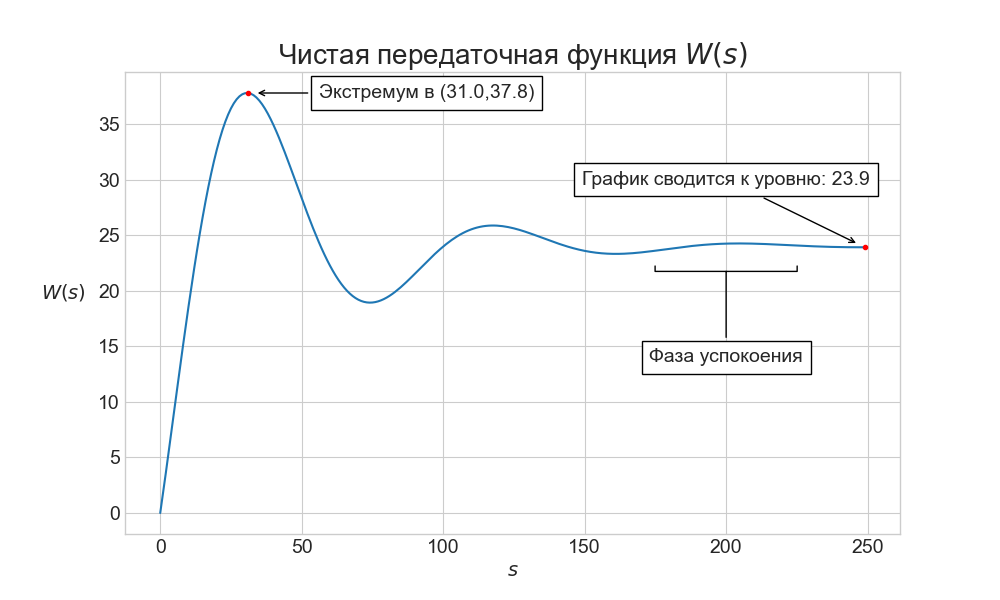

In [17]:
# Визуализация 
plt.style.use('seaborn-whitegrid')

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(clean_result)

ax.set_xlabel('$s$', fontsize=14)
ax.set_ylabel('$W(s)$', fontsize=14, rotation=0, labelpad=25)
ax.set_title('Чистая передаточная функция $W(s)$', fontsize=20)

# Аннотации
max_dot = (clean_result.index(max(clean_result)), max(clean_result))
ax.plot(max_dot[0], max_dot[1], ".r")
offsetbox = TextArea(f"Экстремум в ({max_dot[0]:2.1f},{max_dot[1]:2.1f})")
annotate_max = AnnotationBbox(offsetbox, max_dot,
                    xybox=(0.25,max_dot[1]),
                    xycoords='data',
                    boxcoords=("axes fraction", "data"),
                    box_alignment=(0., 0.5),
                    arrowprops=dict(arrowstyle='->, head_length=0.2, head_width=0.1', shrinkB=7))
ax.add_artist(annotate_max)

offsetbox = TextArea(f"Фаза успокоения")
phase = AnnotationBbox(offsetbox, (200, clean_result[200]),
                    xybox=(200, 14),
                    xycoords='data',
                    boxcoords=('data'),
                    box_alignment=(0.5, 0.5),
                    arrowprops=dict(
                        arrowstyle='-[, widthB=2.63',
                        shrinkB=20)
                      )
ax.add_artist(phase)

normal_dot = (249, clean_result[-1])
ax.plot(normal_dot[0], normal_dot[1], ".r")
offsetbox = TextArea(f"График сводится к уровню: {normal_dot[1]:2.1f}")
annotate_normal = AnnotationBbox(offsetbox, normal_dot,
                    xybox=(200, 30),
                    xycoords='data',
                    boxcoords=("data", "data"),
                    box_alignment=(0.5, 0.5),
                    arrowprops=dict(arrowstyle='->, head_length=0.2, head_width=0.1', shrinkB=7))
ax.add_artist(annotate_normal)


plt.show()

## 2 Этап. Формирования ГСЧ методом Мюллера

**Закон распределения**:
* $ Z_1 = \cos{(2\pi * r_1)} * \sqrt{-2 * ln(r_2)}$

или

* $ Z_2 = \sin{(2\pi * r_1)} * \sqrt{-2 * ln(r_2)}$

Статистики таких чисел будут равны: $ m_V = 0 $ и $ \sigma_V = 1 $

**Масштабирование**: 

$ x = z * \sigma_x + m_x $, где

$ \sigma_x = \Delta y = 0.05 * MAX_{табличный} |y(t)| $

In [18]:
def generate_muller(size:int, dy:float) -> List[float]:
    """
    size: int - размер выборки
    dy: float - параметр масштабирования
    return: List[float] - Массив, сгенерированный по закону Нормального распределения
    """
    arr = []
    sx = 0.05 * 37.93984 # из РГР-1
    for _ in range(size // 2):
        r1, r2 = random(size=2)
        z1: float = np.cos(2 * np.pi * r1) * np.sqrt(-2 * math.log(r2))
        z2: float = np.sin(2 * np.pi * r1) * np.sqrt(-2 * math.log(r2))
        arr.extend([z1 * sx, z2 * sx])
    return arr

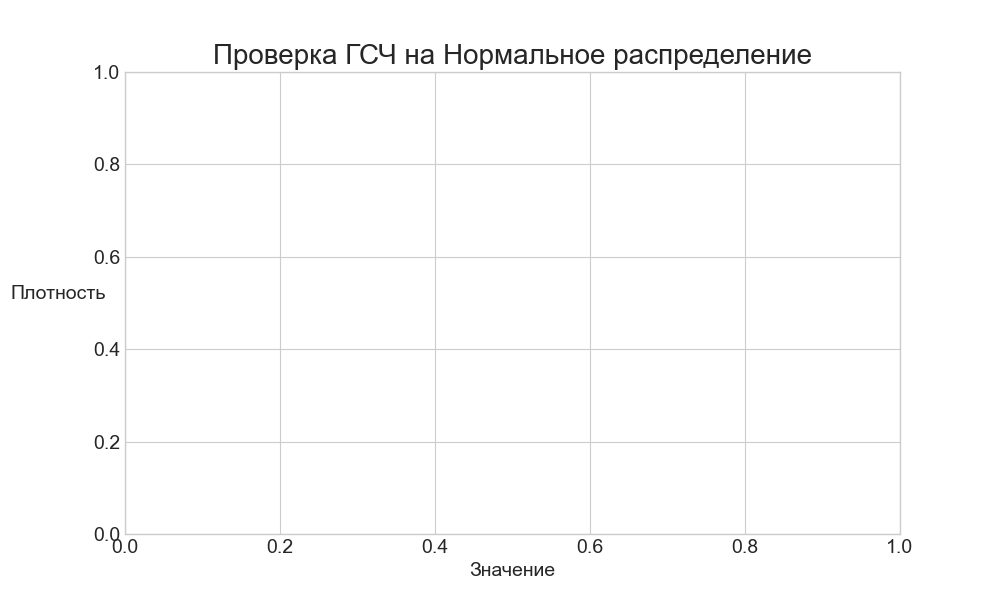

In [19]:
# проверка на нормальное распределение и визуализация
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('Значение', fontsize=14)
ax.set_ylabel('Плотность', fontsize=14, rotation=0, labelpad=25)
ax.set_title('Проверка ГСЧ на Нормальное распределение', fontsize=20)

def update_plot(size):
    global ax,s
    size *= 10
    
    ax.clear()
    ax.set_xlim(-8, 8)
    ax.set_ylim(0, 0.4)
    ax=sns.kdeplot(generate_muller(size, dy=max(clean_result)))
    ax.set_xlabel('Значение', fontsize=14)
    ax.set_ylabel('Плотность', fontsize=14, rotation=90, labelpad=25)
    ax.set_title('Проверка ГСЧ на Нормальное распределение', fontsize=20)
    
    offsetbox = TextArea(f"Размер выборки: {size}")
    phase = AnnotationBbox(offsetbox, (6, 0.3),
                        xybox=(6, 0.3),
                        xycoords='data',
                        boxcoords=('data'),
                        box_alignment=(0.5, 0.5))
    ax.add_artist(phase)
    
anim = animation.FuncAnimation(fig, update_plot, frames=30, interval=50, blit=True, repeat=False)
plt.show()

## Этап 3. Формирования шума. "Зашумление" выходного сигнала придаточной функции. График "зашумленной" функции

In [10]:
# Формирование шума
dy = max(clean_result)
noise = generate_muller(len(clean_result), dy=dy)

In [25]:
# Зашумление
noise_result = [n1+n2 for (n1, n2) in zip(clean_result, noise)]

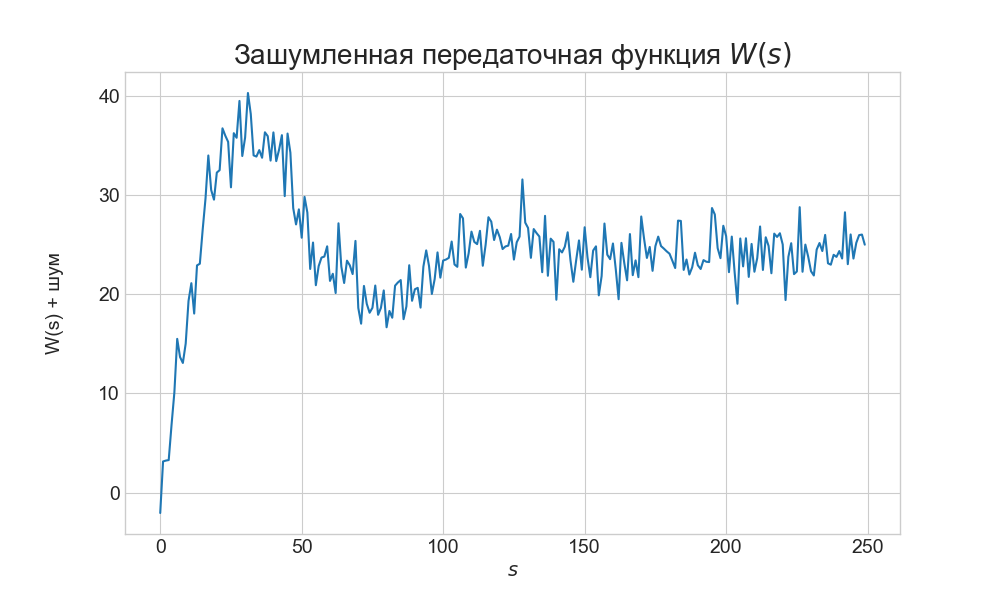

In [30]:
# Визуализация 
plt.style.use('seaborn-whitegrid')

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(noise_result)

ax.set_xlabel('$s$', fontsize=14)
ax.set_ylabel('W(s) + шум', fontsize=14, rotation=90, labelpad=25)
ax.set_title('Зашумленная передаточная функция $W(s)$', fontsize=20)

plt.show()
